In [1]:
%env OMP_NUM_THREADS=8

env: OMP_NUM_THREADS=8


In [2]:
%pylab inline
import time
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import theano
theano.config.floatX = 'float32'
import theano.tensor as T

Populating the interactive namespace from numpy and matplotlib


In [3]:
from itertools import *
import pickle
#from hep_ml.reweight import BinsReweighter
import numpy as np
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split

In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../utils')
import dem

In [161]:
%pylab inline
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

class xgbClf:
    xgb_clf = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.05, max_depth = 5, min_child_weight = 2)
    xtest_ex = []
    def __init__(self,name = 'default_z'):
        self.name = name
    def fit(self, X_train, y_train):
        print "start fitting"
        self.xgb_clf.fit(dem.rev_(X_train), y_train)
        #self.write(name)
        print "fitting succeed"
    def count_score(self, X_val, y_val):
        valid_answ = self.xgb_clf.predict_proba(dem.rev_(X_val))
        self.valid_answ = valid_answ
        print "On val:", roc_auc_score(y_val, valid_answ[:,1])
        fpr_, tpr_, thresholds_ = roc_curve(y_val, valid_answ[:,1])
        plt.plot(fpr_, tpr_, label="Roc-Curve")
        plt.savefig("2area_all.png")
        
    def predict_prob(self,test_sample):
        return self.xgb_clf.predict_proba(test_sample)
    def write (self, file_name):
        import pickle
        print "storing classifier in file", file_name,"...",
        pickle.dump(self.xgb_clf, open (file_name, "wb"))
        print " ...done"

Populating the interactive namespace from numpy and matplotlib


## Separate fitting full and boundary square ##

** Stack datasets **

In [40]:
(X_train0,X_val0,y_train0,y_val0, area_train0, area_val0), (X_train_rec0,X_val_rec0,y_train_rec0,y_val_rec0, area_train_rec0, area_val_rec0) = dem.preprocess2('../../../obt_data/Pi0Area0.pcl', '../../../obt_data/PhArea0.pcl')

area list len: 29895 3617
area list len: 63530 37687
X_all shape2 (93425, 2, 5, 5)
arealist shapes (29895, 2) (63530, 2)
(2,)
X_all shape2 (41304, 2, 5, 5)
(2,)


start fitting
fitting succeed
On val: 0.999457336889


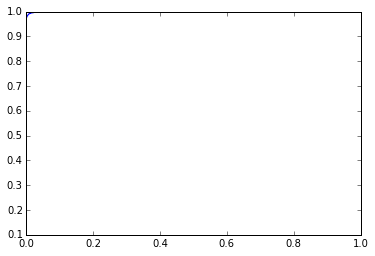

In [162]:
clf1_simple= xgbClf('1_simpl')
clf1_simple.fit(X_train, y_train)
clf1_simple.count_score(X_val, y_val)

start fitting
fitting succeed
On val: 0.996597537335


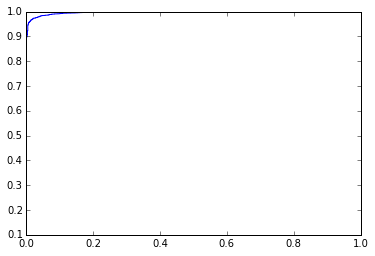

In [163]:
clf1_bound= xgbClf('1_bound')
clf1_bound.fit(X_train_rec, y_train_rec)
clf1_bound.count_score(X_val_rec, y_val_rec)

start fitting
fitting succeed
On val: 0.958288390905


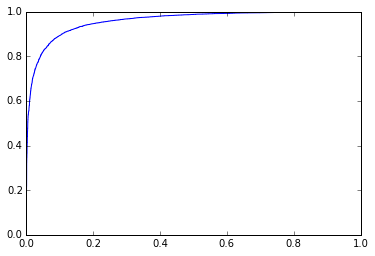

In [166]:
clf2_simple= xgbClf('2_simpl')
clf2_simple.fit(X_train2, y_train2)
clf2_simple.count_score(X_val2, y_val2)

start fitting
fitting succeed
On val: 0.956488365876


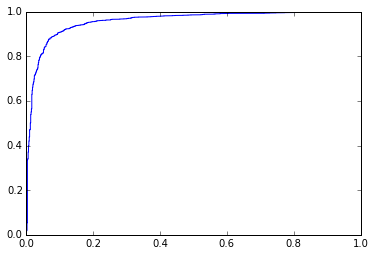

In [167]:
clf2_bound= xgbClf('2_bound')
clf2_bound.fit(X_train_rec2, y_train_rec2)
clf2_bound.count_score(X_val_rec2, y_val_rec2)

start fitting
fitting succeed
On val: 0.999969494618


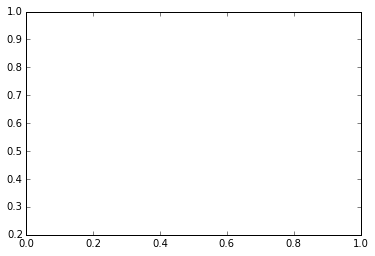

In [169]:
clf0_simple= xgbClf('0_simpl')
clf0_simple.fit(X_train0, y_train0)
clf0_simple.count_score(X_val0, y_val0)

TRAIN 30978 VAL 10326
start fitting
fitting succeed
On val: 0.999913670333


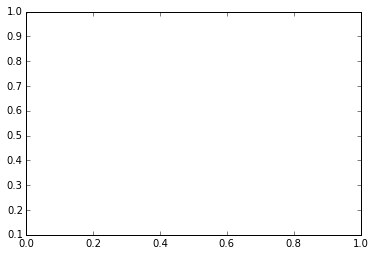

In [171]:
print "TRAIN", len(X_train_rec0), "VAL", len(X_val_rec0)
clf0_bound= xgbClf('0_bound')
clf0_bound.fit(X_train_rec0, y_train_rec0)
clf0_bound.count_score(X_val_rec0, y_val_rec0)

## Common classifier ##

In [93]:
classifiers = {1:{0:clf1_simple, 1:clf1_bound}, 0:{0:clf0_simple, 1:clf0_bound}, 2:{0:clf2_simple, 1:clf2_bound}}

In [81]:
X_common_val = np.concatenate([X_val0, X_val, X_val2, X_val_rec0, X_val_rec, X_val_rec2], axis = 0)
Y_common_val = np.concatenate([y_val0, y_val, y_val2, y_val_rec0, y_val_rec, y_val_rec2], axis = 0)
Common_clf = np.concatenate([area_val0, area_val, area_val2, area_val_rec0, area_val_rec, area_val_rec2], axis = 0)
shuffle_ind = np.arange(len(X_common_val))
np.random.shuffle(shuffle_ind)
X_common_val = X_common_val[shuffle_ind]
Y_common_val = Y_common_val[shuffle_ind]
Common_clf = Common_clf[shuffle_ind]

In [152]:
def common_prediction(X_common_val, Common_clf):
    answ = []
    for (X_val, clf) in (zip(X_common_val, Common_clf)):
        try:
            clf_partial = classifiers[clf[0]][clf[1]]
            answ.append(clf_partial.xgb_clf.predict_proba(dem.rev_(X_val.reshape((1,2,5,5))))[0][1])
        except:
            print "clf", clf
    return answ

In [155]:
answ1 = common_prediction(X_common_val, Common_clf)

On val: 0.922000987695


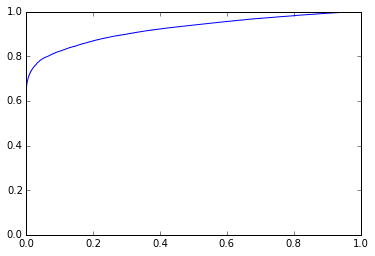

In [157]:
print "On val:", roc_auc_score(Y_common_val, np.array(answ1))
fpr_, tpr_, thresholds_ = roc_curve(Y_common_val,np.array(answ1))
plt.plot(fpr_, tpr_, label="Roc-Curve")
plt.savefig("common_classifier.png")